- Labels in this dataset:
    - 0: fish
    - 1: jellyfish
    - 2: penguin
    - 3: puffin
    - 4: shark
    - 5: starfish
    - 6: stingray


- More info:
    - Number of classes: 7
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`
      
___      

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-46dcb166-4a8f-1ecc-c47c-27ec620814be)
GPU 1: Tesla T4 (UUID: GPU-9f4b5dc8-3aaf-0ac6-9730-1aaaba1a823b)


# Installs/Imports

In [2]:
%%time

! pip install --upgrade ultralytics -qq


CPU times: user 172 ms, sys: 48.1 ms, total: 220 ms
Wall time: 14.2 s


In [3]:
import ultralytics
print(ultralytics.__version__)

8.1.37


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import torch

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [4]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation
- Set `DEBUG = True` to make quick experiments

In [5]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 1

    # classes
    NUM_CLASSES = 7
    CLASSES = ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

    # training
    EPOCHS = 100 
    BATCH_SIZE = 32
    
    BASE_MODEL = 'yolov8n' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 0.001
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/'
    OUTPUT_DIR = '/kaggle/working/'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- fish
- jellyfish
- penguin
- puffin
- shark
- starfish
- stingray
nc: 7
test: /kaggle/input/aquarium-data-cots/aquarium_pretrain/test
train: /kaggle/input/aquarium-data-cots/aquarium_pretrain/train
val: /kaggle/input/aquarium-data-cots/aquarium_pretrain/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (1024, 768, 3) 



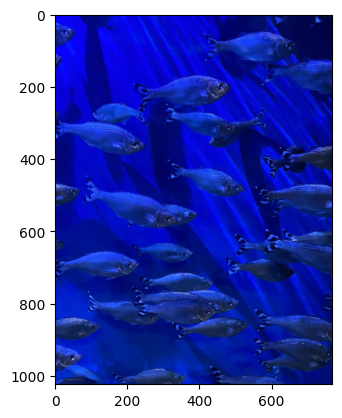

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()
    
example_image_path = '/kaggle/input/aquarium-data-cots/aquarium_pretrain/train/images/IMG_2274_jpeg_jpg.rf.2f319e949748145fb22dcb52bb325a0c.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

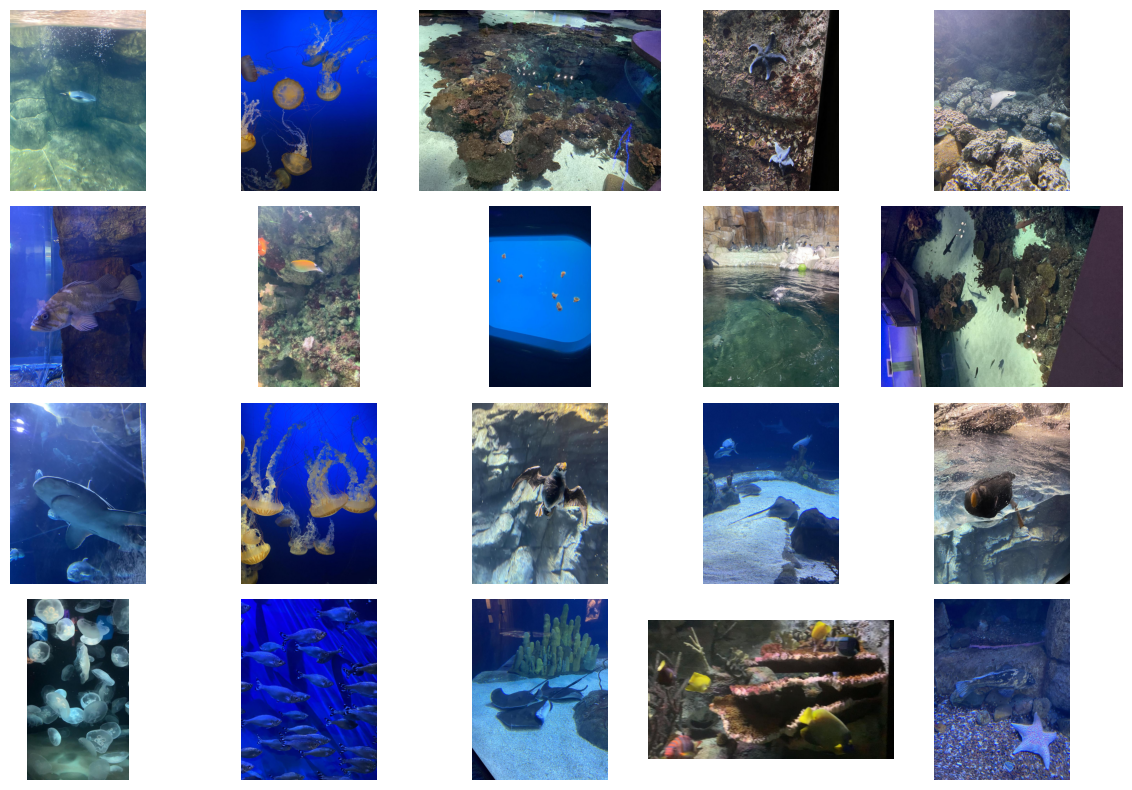

In [10]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()
    
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

## Image properties

In [11]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 768, 'height': 1024, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [15]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 53 ms, sys: 41 ms, total: 94 ms
Wall time: 4.38 s


Mode  fish  jellyfish  penguin  puffin  shark  starfish  stingray  \
0  train   240         32       47      45    134        37        91   
1  valid    63          9       17      15     28        17        23   
2   test    30         11        7       6     14         5        10   

   Data_Volume  
0          448  
1          127  
2           63

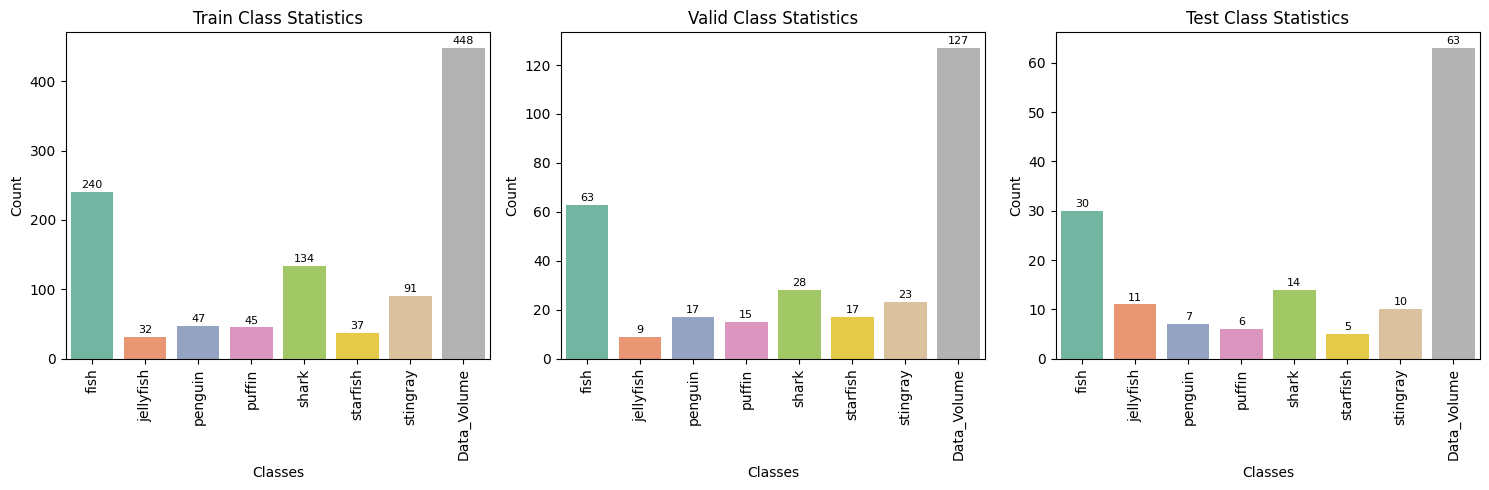

In [16]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [ ]:
# %%time

# for mode in ['train', 'valid', 'test']:
#     print(f'\nImage sizes in {mode} set:')

#     img_size = 0
#     for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

#         image = Image.open(file)

#         if image.size != img_size:
#             print(f'{image.size}')
#             img_size = image.size
#             print('\n')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [17]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8n.pt
Epochs:  100
Batch:  32


In [7]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
!pip install -U ipywidgets

In [ ]:
# import torch
# torch.cuda.empty_cache()
# cuda_available = torch.cuda.is_available()
# print(cuda_available)

In [ ]:
%%time

### train
results = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (img_properties['height'], img_properties['width']),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov8n_underwater')

# Export

In [ ]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_underwater/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Evaluation

In [ ]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_underwater/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")    
print(f"Mean Average Precision @ .50   : {metrics.box.map50}") 
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

# Test model


In [ ]:
results = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline

predicitions = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/predict', '*'))

n = 10

for i in range(n):
    idx = np.random.randint(0, len(predicitions))
    image = Image.open(predicitions[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()

# Retrain model use augmention data

In [6]:
path = '/kaggle/input/underwater-augmention/aquarium_pretrain_augmention'
dict_file = {
    'train': os.path.join(path, 'train'),
    'val': os.path.join(path, 'valid'),
    'nc': CFG.NUM_CLASSES,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [7]:
### read yaml file created

def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- fish
- jellyfish
- penguin
- puffin
- shark
- starfish
- stingray
nc: 7
train: /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train
val: /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid



In [14]:
#retrain use model best.pt
model = YOLO('/kaggle/working/runs/detect/yolov8n_underwater_augumention/weights/best.pt')

results_aug = model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data_aug.yaml'),
    epochs = 100,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    imgsz = (1024, 768),
    seed = CFG.SEED,
    device = [0,1], #[0,1], # 0
    workers=4,
    name='yolov8n_underwater_augumention2')

Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/yolov8n_underwater_augumention/weights/best.pt, data=/kaggle/working/data_aug.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=(1024, 768), save=True, save_period=-1, cache=False, device=[0, 1], workers=4, project=None, name=yolov8n_underwater_augumention2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnost

2024-03-29 16:23:50.623115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 16:23:50.623171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 16:23:50.624923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8n_underwater_augumention2', view at http://localhost:6006/
Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train/labels... 894 images, 447 backgrounds, 0 corrupt: 100%|██████████| 1341/1341 [00:01<00:00, 980.47it/s] 


train: WARNING ⚠️ Cache directory /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid/labels... 381 images, 0 backgrounds, 0 corrupt: 100%|██████████| 381/381 [00:00<00:00, 562.26it/s]/s]
train: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train/labels... 446 images, 0 backgrounds, 0 corrupt:  33%|███▎      | 446/1341 [00:00<00:01, 569.59it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid is not writeable, cache not saved.


train: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/train/labels... 894 images, 447 backgrounds, 0 corrupt: 100%|██████████| 1341/1341 [00:01<00:00, 823.98it/s] 


Plotting labels to runs/detect/yolov8n_underwater_augumention2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8n_underwater_augumention2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.22G     0.8891     0.7527      1.039         95       1024: 100%|██████████| 42/42 [00:34<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


                   all        381       2721      0.665      0.631      0.634      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.15G      1.021     0.9037      1.121         92       1024: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


                   all        381       2721      0.679      0.597      0.608      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.19G      1.048     0.9501      1.105        140       1024: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


                   all        381       2721       0.59      0.584      0.535       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.72G      1.096      1.037      1.141        182       1024: 100%|██████████| 42/42 [00:29<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


                   all        381       2721      0.652      0.561      0.558       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.06G      1.133      1.068      1.153         80       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


                   all        381       2721      0.608      0.583      0.566      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.86G      1.117      1.007      1.151         92       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


                   all        381       2721      0.637      0.576      0.582      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.55G       1.13      1.005      1.138        183       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


                   all        381       2721      0.596      0.554      0.536      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.05G      1.146      1.059      1.161         46       1024: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


                   all        381       2721      0.577      0.555      0.529      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.03G      1.121      1.004      1.133         90       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]


                   all        381       2721      0.635      0.604      0.599      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.76G      1.112     0.9814       1.14        143       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


                   all        381       2721      0.572       0.51      0.505      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.94G      1.121     0.9888      1.144         82       1024: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


                   all        381       2721      0.712      0.571      0.603      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.56G      1.093      1.004      1.136        147       1024: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


                   all        381       2721      0.614      0.544      0.534      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.35G      1.107     0.9847      1.122         47       1024: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]


                   all        381       2721       0.55      0.584      0.539      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.35G      1.083      1.006      1.134         99       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


                   all        381       2721      0.617      0.517      0.529      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.77G      1.072     0.9355      1.113        104       1024: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


                   all        381       2721      0.616      0.558      0.553      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.43G      1.081     0.9584      1.126        100       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


                   all        381       2721      0.662      0.591      0.613      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.44G      1.075     0.9559      1.112         84       1024: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


                   all        381       2721      0.664      0.552      0.568      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.07G      1.089     0.9497      1.117        221       1024: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


                   all        381       2721      0.613       0.54      0.513      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       5.7G      1.046     0.9393      1.107         60       1024: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


                   all        381       2721      0.639      0.567      0.554      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.07G      1.048     0.9092      1.111        110       1024: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


                   all        381       2721      0.634      0.603        0.6      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         6G      1.075     0.9359      1.119        116       1024: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


                   all        381       2721      0.631      0.613      0.582      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.73G      1.091     0.9407      1.122        148       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


                   all        381       2721      0.614      0.597      0.567      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         6G      1.088     0.9283       1.11        132       1024: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


                   all        381       2721       0.68      0.593      0.606      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.11G      1.066     0.9705      1.104        114       1024: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


                   all        381       2721       0.65      0.585      0.591      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.33G      1.014     0.8789      1.089        100       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


                   all        381       2721      0.653        0.6      0.589      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.32G      1.064     0.9544      1.125         65       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


                   all        381       2721      0.608        0.6      0.588      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.44G       1.08     0.9447      1.126        135       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


                   all        381       2721      0.629      0.579      0.554      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.43G      1.048     0.9085      1.101         70       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


                   all        381       2721      0.683      0.612      0.625      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.66G      1.016     0.9562      1.096         93       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


                   all        381       2721      0.625      0.593      0.579      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.77G      1.061     0.9226      1.109        111       1024: 100%|██████████| 42/42 [00:29<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


                   all        381       2721      0.619      0.638      0.611      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.29G      1.067     0.9033      1.104         66       1024: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


                   all        381       2721      0.698      0.587      0.617      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.27G      1.015     0.8648      1.076         68       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


                   all        381       2721       0.65      0.614      0.613      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.94G      1.027      0.907      1.096        191       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


                   all        381       2721      0.641      0.648      0.612      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.38G      1.017     0.8761       1.11        141       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


                   all        381       2721      0.646      0.619      0.607      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.12G     0.9667     0.8081      1.045         96       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


                   all        381       2721      0.662      0.609      0.593      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.06G      1.004     0.8798      1.081        125       1024: 100%|██████████| 42/42 [00:30<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


                   all        381       2721      0.651      0.612      0.613      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.37G     0.9875     0.8315      1.073        202       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


                   all        381       2721      0.666      0.643      0.626      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.78G     0.9904     0.8959      1.084        105       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


                   all        381       2721      0.717      0.591      0.626      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.99G     0.9764     0.8268      1.062         68       1024: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


                   all        381       2721      0.698      0.616       0.63      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.47G     0.9715     0.8238      1.054         93       1024: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721      0.661      0.617      0.607      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.79G      1.003     0.8545      1.084        154       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


                   all        381       2721      0.649      0.614      0.609      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.71G      0.989     0.8407      1.063        171       1024: 100%|██████████| 42/42 [00:29<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


                   all        381       2721      0.644      0.601      0.596      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.39G      0.968     0.8554      1.071        107       1024: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


                   all        381       2721      0.665      0.574      0.595      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.33G     0.9759     0.8304      1.067        110       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


                   all        381       2721      0.681      0.621      0.623      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.05G     0.9859     0.8157      1.068        124       1024: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


                   all        381       2721      0.696      0.614      0.642       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.94G     0.9557       0.84      1.065        119       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


                   all        381       2721      0.697        0.6      0.633      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       6.8G     0.9677     0.8381      1.068        104       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


                   all        381       2721      0.651      0.602        0.6      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       5.8G     0.9428     0.7878      1.052        106       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


                   all        381       2721      0.638       0.59      0.581      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.38G     0.9414     0.8018      1.044        134       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


                   all        381       2721      0.655      0.593      0.595       0.31

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.03G     0.9504     0.8036      1.047        196       1024: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


                   all        381       2721       0.65      0.582       0.59      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.83G     0.9431     0.7984      1.059         90       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


                   all        381       2721       0.66       0.61      0.624      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.06G     0.9227     0.7905      1.045         84       1024: 100%|██████████| 42/42 [00:29<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


                   all        381       2721      0.655      0.618      0.624      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.05G     0.9131     0.7614       1.03         68       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


                   all        381       2721      0.681      0.629       0.64      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.65G     0.9693     0.8153      1.056        146       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


                   all        381       2721      0.687      0.606      0.628      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.73G     0.9455      0.774      1.042        108       1024: 100%|██████████| 42/42 [00:30<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


                   all        381       2721      0.622      0.601      0.583      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.04G     0.9339     0.7823       1.05        127       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


                   all        381       2721      0.649      0.617      0.606      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.47G     0.9563      0.825      1.071        100       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


                   all        381       2721      0.655      0.592      0.616       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.29G     0.8913     0.7883      1.042         68       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


                   all        381       2721      0.665      0.583      0.612      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.58G     0.8804     0.8092       1.04         79       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


                   all        381       2721      0.637      0.631      0.627      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       6.7G     0.8989     0.7627      1.021        124       1024: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


                   all        381       2721      0.651      0.564      0.586      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.18G     0.8966     0.7674      1.024        140       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]


                   all        381       2721      0.695      0.618      0.636      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.27G     0.8929     0.7842      1.029        105       1024: 100%|██████████| 42/42 [00:29<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721      0.659      0.616      0.609      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.38G     0.8851     0.7513       1.02        115       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


                   all        381       2721      0.676      0.617      0.632      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.46G     0.8694     0.7398      1.017        148       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


                   all        381       2721      0.729      0.603      0.646      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.42G     0.8703     0.7334      1.008        104       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


                   all        381       2721      0.664      0.615       0.62      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.06G     0.8969     0.7827      1.027         75       1024: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


                   all        381       2721      0.634      0.601       0.59      0.311

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.89G     0.9128     0.7681      1.034        111       1024: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


                   all        381       2721      0.654      0.612      0.595      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.41G     0.8672     0.7624      1.026        146       1024: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


                   all        381       2721      0.645      0.602      0.597      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.29G     0.8864     0.7474      1.022        104       1024: 100%|██████████| 42/42 [00:28<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


                   all        381       2721       0.64      0.582      0.582      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.96G     0.9189     0.8013      1.045         67       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


                   all        381       2721        0.7        0.6       0.63      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.25G     0.9036     0.7499      1.027        199       1024: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


                   all        381       2721      0.684      0.624      0.635      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.31G      0.908     0.7373      1.039        111       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


                   all        381       2721      0.657      0.622      0.618      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.73G     0.8909     0.7342      1.026        138       1024: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721      0.698      0.593      0.633      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.73G      0.875     0.7145      1.022         99       1024: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721      0.685      0.606      0.624      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.01G     0.8766     0.7481      1.016        216       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721       0.69       0.62      0.646       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.21G     0.8468     0.7227      1.014         65       1024: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


                   all        381       2721      0.673      0.618      0.623      0.328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.35G     0.8438     0.7363      1.022        146       1024: 100%|██████████| 42/42 [00:28<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


                   all        381       2721      0.698      0.621      0.633      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.15G     0.8695     0.7325      1.029         96       1024: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


                   all        381       2721      0.701      0.616      0.636      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.35G     0.8605     0.7201      1.004         80       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


                   all        381       2721      0.686      0.624      0.639      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.21G     0.8154     0.6853      0.999         76       1024: 100%|██████████| 42/42 [00:29<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


                   all        381       2721      0.661      0.608      0.619      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      7.61G     0.8641     0.7016     0.9955        118       1024: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.44it/s]


                   all        381       2721      0.644      0.614      0.622      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.84G     0.8472     0.7047      1.017        114       1024: 100%|██████████| 42/42 [00:28<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


                   all        381       2721      0.677      0.607      0.636      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.94G     0.8378     0.7048      1.017         44       1024: 100%|██████████| 42/42 [00:29<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


                   all        381       2721      0.652      0.611      0.619      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.63G     0.8415     0.6802      1.008        132       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


                   all        381       2721      0.676      0.617      0.627       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.95G     0.8158     0.7166      1.001        193       1024: 100%|██████████| 42/42 [00:28<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]


                   all        381       2721      0.688      0.618      0.647      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100       6.1G     0.8148     0.6648     0.9977        161       1024: 100%|██████████| 42/42 [00:29<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


                   all        381       2721      0.688      0.626      0.636      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.51G     0.8488     0.6982      1.007        150       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


                   all        381       2721       0.66      0.645      0.637      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.02G      0.825     0.7091       1.01        116       1024: 100%|██████████| 42/42 [00:27<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.15it/s]


                   all        381       2721      0.654      0.622      0.621      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.23G     0.8252     0.6798      0.991        138       1024: 100%|██████████| 42/42 [00:29<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


                   all        381       2721       0.65      0.623      0.622      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       6.1G     0.8363     0.6832     0.9967        155       1024: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


                   all        381       2721      0.657      0.631      0.628      0.336
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.81G     0.8365     0.7053       1.01         79       1024: 100%|██████████| 42/42 [00:30<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


                   all        381       2721      0.671      0.627      0.634      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.54G     0.7799      0.629     0.9776         78       1024: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.47it/s]


                   all        381       2721      0.655      0.635      0.631       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.05G     0.7774     0.6226     0.9792         33       1024: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.51it/s]


                   all        381       2721      0.652      0.647      0.636      0.345

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.02G     0.7867     0.6341     0.9729         76       1024: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


                   all        381       2721      0.653      0.625       0.63      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.07G     0.7823     0.6481     0.9753         70       1024: 100%|██████████| 42/42 [00:26<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


                   all        381       2721      0.656      0.626      0.625      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.66G     0.7717     0.6386     0.9771         69       1024: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721      0.662      0.627      0.629      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       5.7G     0.7518     0.6234     0.9637         33       1024: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


                   all        381       2721      0.659      0.632      0.629      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.24G     0.7471     0.6389     0.9546         39       1024: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


                   all        381       2721      0.673      0.627      0.635      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.71G     0.7591     0.6033     0.9751         96       1024: 100%|██████████| 42/42 [00:25<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.45it/s]


                   all        381       2721      0.655      0.626      0.628       0.34

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.96G     0.7352     0.5953     0.9498         43       1024: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


                   all        381       2721      0.665      0.629      0.632      0.343

100 epochs completed in 0.974 hours.
Optimizer stripped from runs/detect/yolov8n_underwater_augumention2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8n_underwater_augumention2/weights/best.pt, 6.3MB

Validating runs/detect/yolov8n_underwater_augumention2/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


                   all        381       2721       0.69      0.618      0.647      0.354
                  fish        381       1376      0.696       0.67      0.697      0.381
             jellyfish        381        462      0.786      0.836       0.85      0.468
               penguin        381        310      0.569      0.655      0.591      0.256
                puffin        381        222      0.631      0.331      0.421      0.205
                 shark        381        171      0.605      0.561       0.58      0.337
              starfish        381         81      0.842      0.642       0.72      0.406
              stingray        381         99      0.698      0.631      0.672      0.426
Speed: 0.5ms preprocess, 5.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/yolov8n_underwater_augumention2


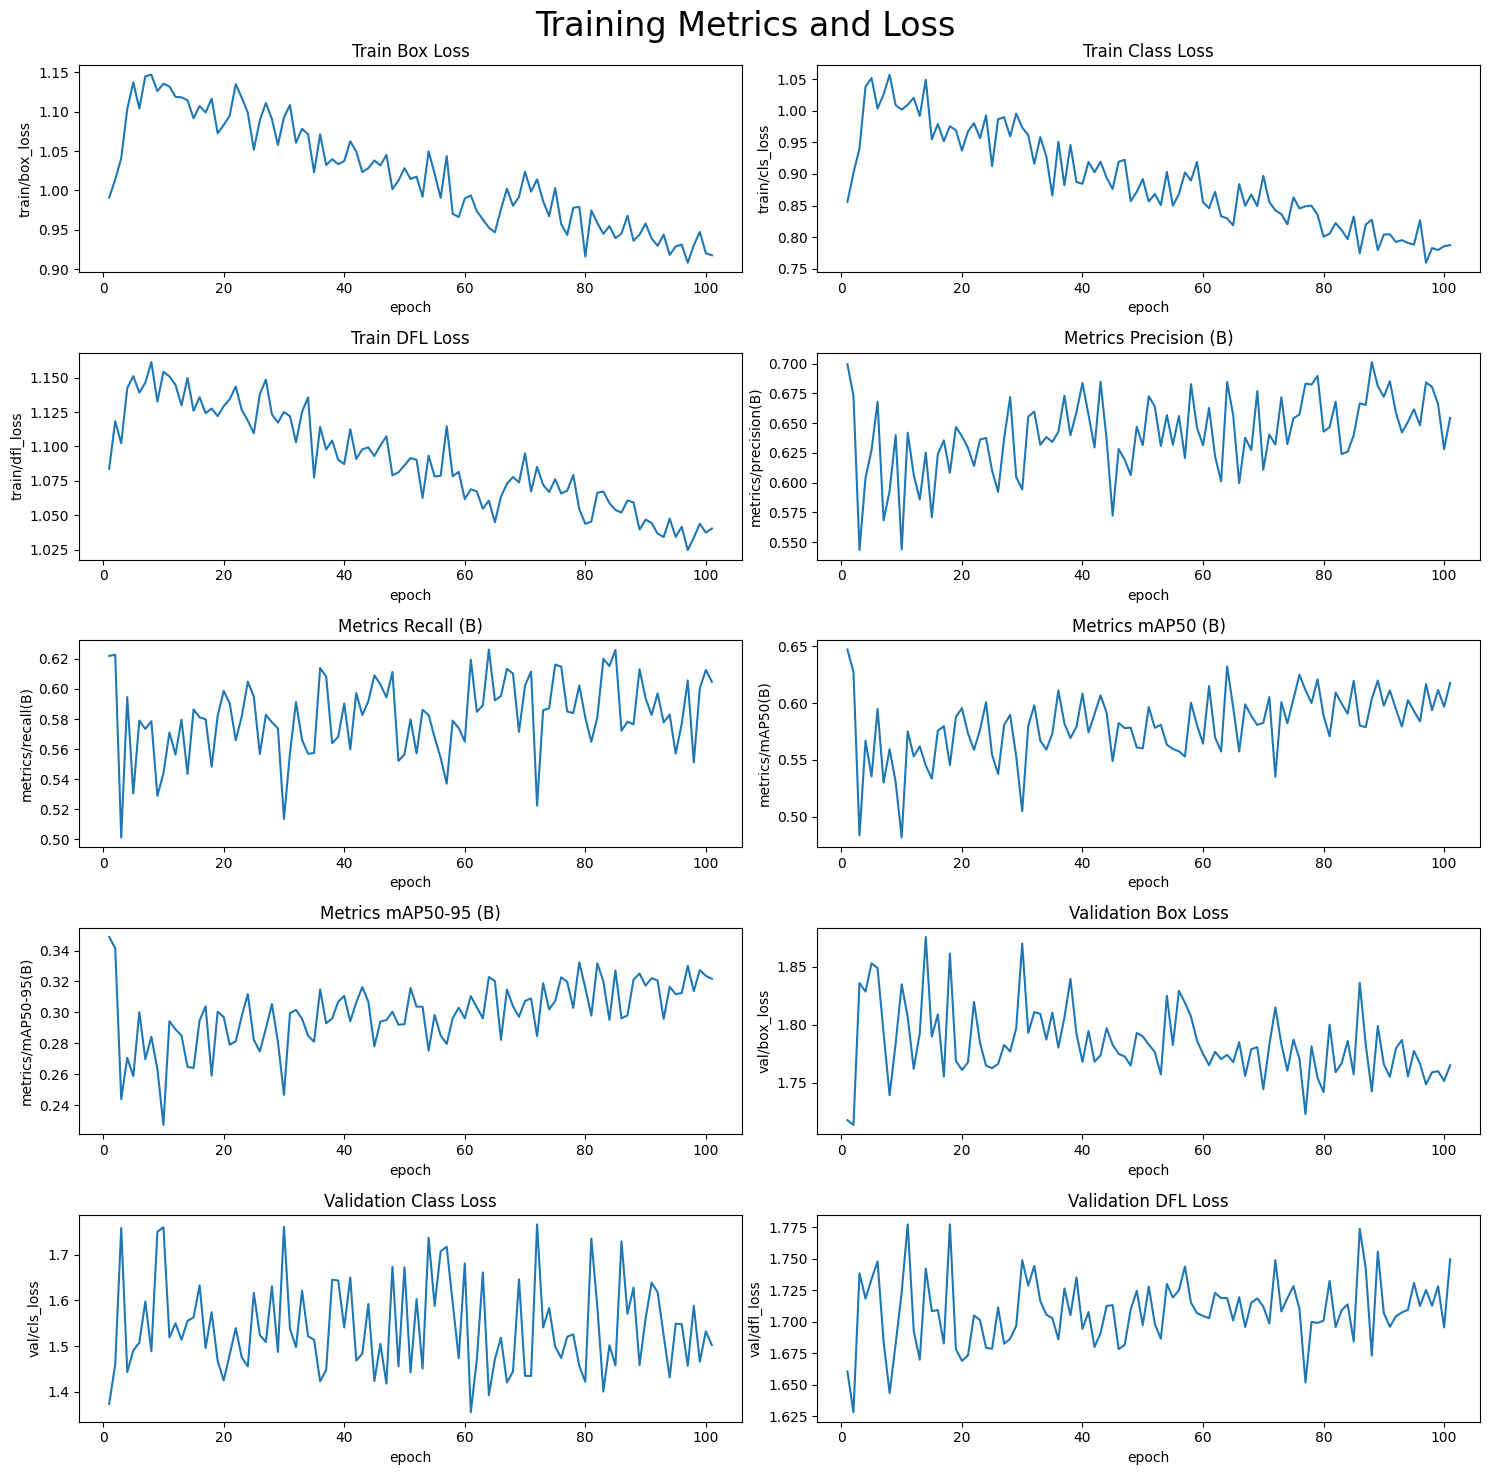

In [15]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/yolov8n_underwater_augumention/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

In [16]:

model.val()

Ultralytics YOLOv8.1.37 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007013 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid/labels... 381 images, 0 backgrounds, 0 corrupt: 100%|██████████| 381/381 [00:00<00:00, 710.90it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/underwater-augmention/aquarium_pretrain_augmention/valid is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


                   all        381       2721       0.69      0.618      0.647      0.354
                  fish        381       1376      0.695       0.67      0.698      0.381
             jellyfish        381        462      0.785      0.835      0.849      0.465
               penguin        381        310      0.576      0.655      0.593      0.256
                puffin        381        222      0.631      0.332      0.421      0.204
                 shark        381        171      0.605      0.561       0.58      0.337
              starfish        381         81       0.84      0.642       0.72      0.407
              stingray        381         99      0.698       0.63      0.671      0.426
Speed: 0.7ms preprocess, 10.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/yolov8n_underwater_augumention22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d27109f31f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [17]:
results_aug = model.predict(source=os.path.join(CFG.CUSTOM_DATASET_DIR, 'test', 'images'), save=True)
%matplotlib inline



image 1/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg: 1024x768 (no detections), 11.9ms
image 2/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg: 1024x768 27 penguins, 11.2ms
image 3/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg: 1024x768 13 penguins, 11.2ms
image 4/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg: 1024x768 2 penguins, 11.2ms
image 5/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg: 1024x768 5 penguins, 11.2ms
image 6/63 /kaggle/input/aquarium-data-cots/aquarium_pretrain/test/images/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg: 1024x768 5 fishs, 2 sharks, 11.2ms
image 7/63 /kaggle/

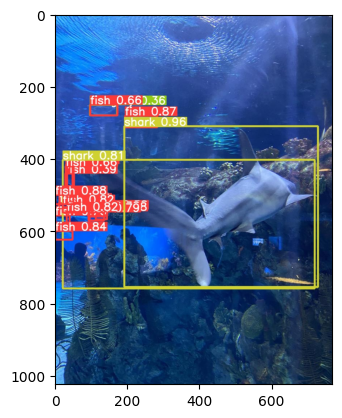

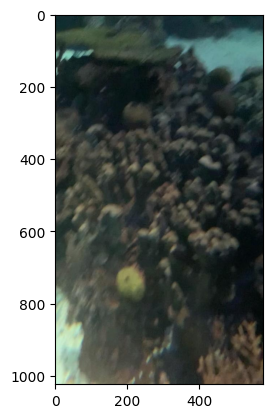

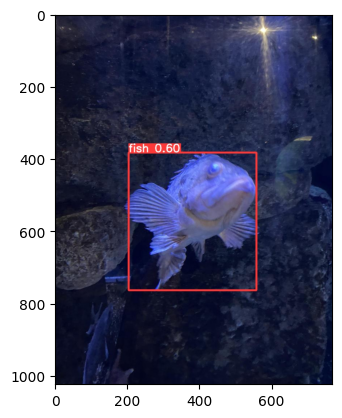

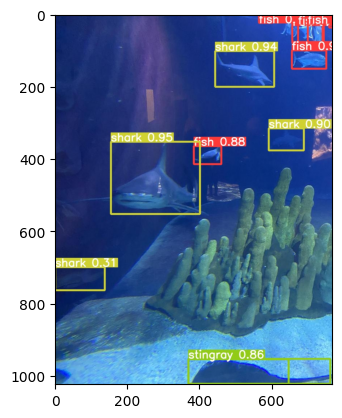

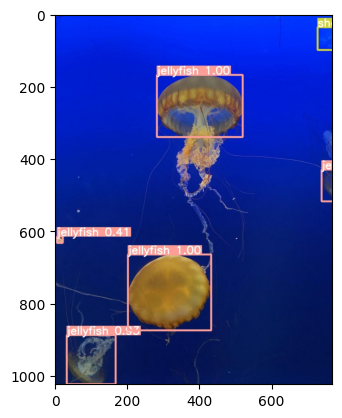

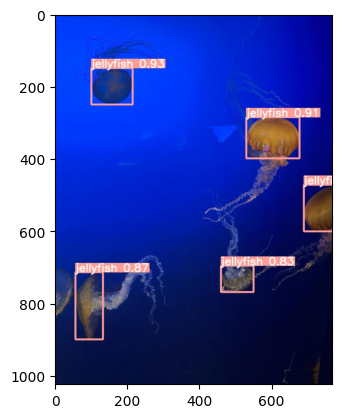

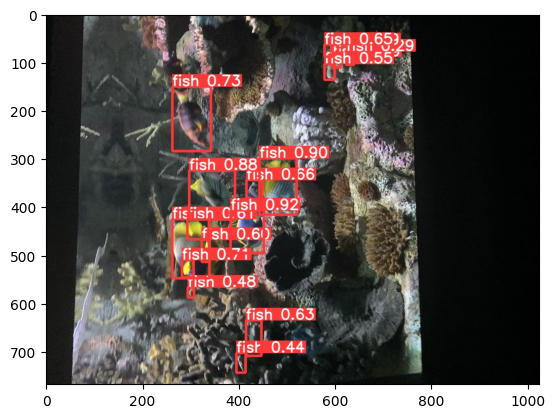

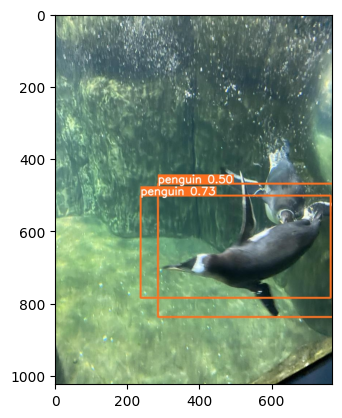

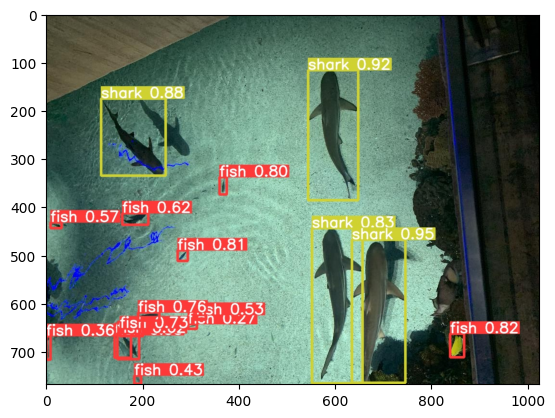

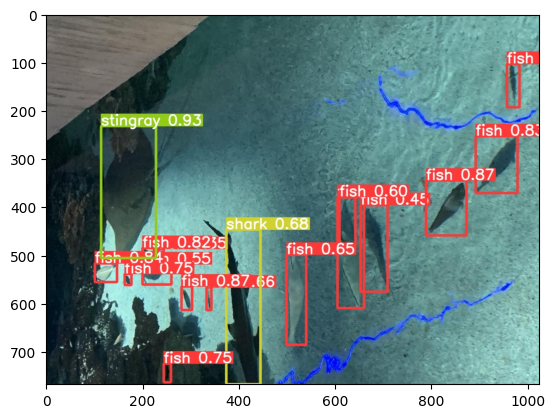

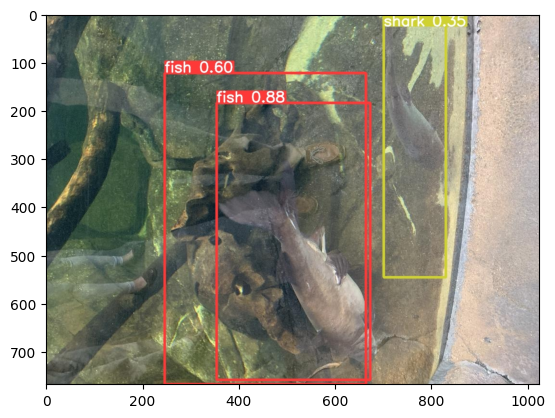

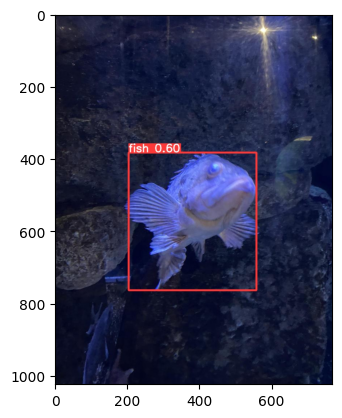

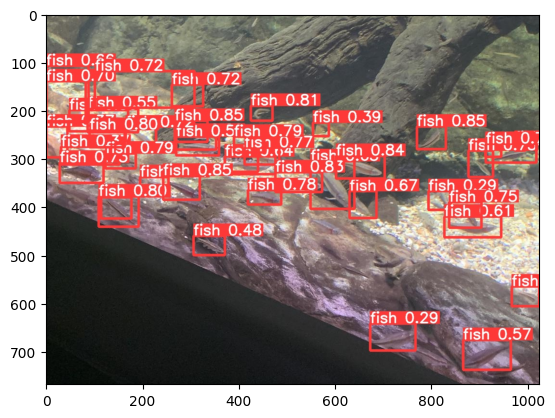

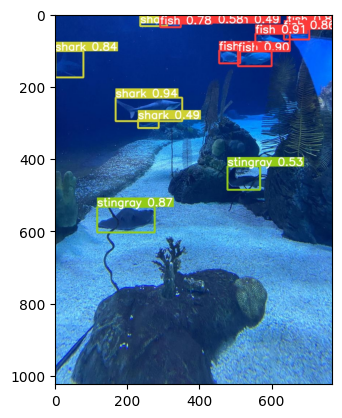

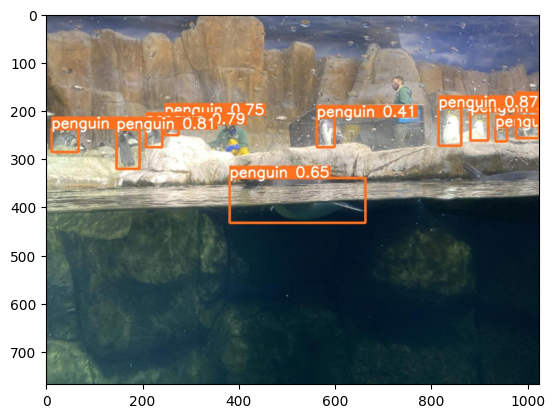

In [18]:

predicitions_aug = glob.glob(os.path.join(CFG.OUTPUT_DIR, 'runs/detect/yolov8n_underwater_augumention23', '*'))

n = 15

for i in range(n):
    idx = np.random.randint(0, len(predicitions_aug))
    image = Image.open(predicitions_aug[idx])
    plt.imshow(image)
    plt.grid(False)
    plt.show()